In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
# 1. Data Preprocessing
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

In [6]:

# Merge customer and transaction data
merged_data = transactions.merge(customers, on="CustomerID", how="inner")

# Merge the merged data with product data to get the 'Category' column
merged_data = merged_data.merge(products, on="ProductID", how="inner")

print(merged_data.columns)
print(merged_data.head())

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4

In [7]:
# 2. Feature Engineering
# Aggregate data to get features for customer segmentation
merged_data.rename(columns={'Price_x': 'TransactionPrice', 'Price_y': 'ProductPrice'}, inplace=True)

# Now, aggregate data
customer_profiles = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",           # Total spending
    "TransactionID": "count",      # Number of transactions
    "TransactionPrice": "mean",    # Average transaction value
    "Region": "first",             # Region (assumes one region per customer)
    "Category": lambda x: x.mode()[0],  # Most frequent category
    "TransactionDate": "max"       # Most recent transaction date
}).reset_index()

# Calculate recency (days since last transaction)
customer_profiles["Recency"] = (pd.to_datetime("today") - pd.to_datetime(customer_profiles["TransactionDate"])).dt.days


print(customer_profiles.head())

  CustomerID  TotalValue  TransactionID  TransactionPrice         Region  \
0      C0001     3354.52              5        278.334000  South America   
1      C0002     1862.74              4        208.920000           Asia   
2      C0003     2725.38              4        195.707500  South America   
3      C0004     5354.88              8        240.636250  South America   
4      C0005     2034.24              3        291.603333           Asia   

      Category      TransactionDate  Recency  
0  Electronics  2024-11-02 17:04:16       86  
1     Clothing  2024-12-03 01:41:41       55  
2   Home Decor  2024-08-24 18:54:04      156  
3        Books  2024-12-23 14:13:52       35  
4  Electronics  2024-11-04 00:30:22       84  


In [8]:
# 3. Clustering (K-Means)
#features for clustering
features = ["TotalValue", "TransactionID", "TransactionPrice", "Recency"]
X = customer_profiles[features]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=5, random_state=42)
customer_profiles["Cluster"] = kmeans.fit_predict(X_scaled)

# Calculate Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(X_scaled, customer_profiles["Cluster"])
print(f"DB Index: {db_index}")

DB Index: 1.182127815562239


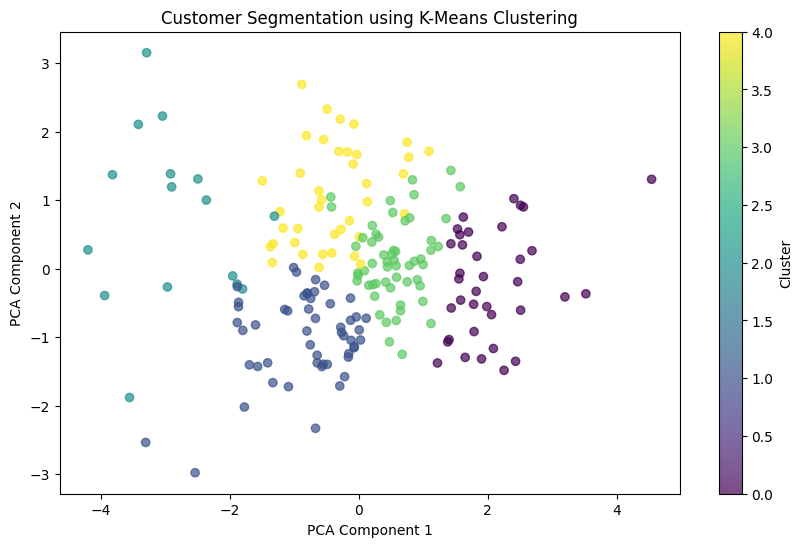

In [9]:
# 4. Visualizing the Clusters
# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the customer profile DataFrame
customer_profiles["PCA1"] = X_pca[:, 0]
customer_profiles["PCA2"] = X_pca[:, 1]


plt.figure(figsize=(10, 6))
plt.scatter(customer_profiles["PCA1"], customer_profiles["PCA2"], c=customer_profiles["Cluster"], cmap='viridis', alpha=0.7)
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
# 5. Cluster Summaries
# Get the mean values for each cluster
cluster_summary = customer_profiles.groupby("Cluster").agg({
    "TotalValue": "mean",
    "TransactionID": "mean",
    "TransactionPrice": "mean",
    "Recency": "mean"
}).reset_index()


print(cluster_summary)

   Cluster   TotalValue  TransactionID  TransactionPrice     Recency
0        0  6045.326389       8.277778        280.850652   64.388889
1        1  2025.192692       4.115385        204.769992   82.980769
2        2  1132.325000       1.812500        239.171979  282.187500
3        3  4210.155357       5.839286        284.608789   99.875000
4        4  2901.740769       3.384615        347.577496  103.641026


In [ ]:
# 6. Save the Clustering Results
customer_profiles.to_csv("Customer_Segmentation_Results.csv", index=False)

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Assume you already have the customer data (X) and cluster labels (labels)
# For example, after K-Means clustering:
kmeans = KMeans(n_clusters=5, random_state=42)  # Assuming you chose 5 clusters
labels = kmeans.fit_predict(X)

# DB Index
db_index = davies_bouldin_score(X, labels)

# Silhouette Score
silhouette_avg = silhouette_score(X, labels)

# Inertia (for K-Means)
inertia = kmeans.inertia_

# Cluster Sizes
cluster_sizes = np.bincount(labels)

# Report Generation
report = f"""
Clustering Report:
----------------------
1. Number of Clusters Formed: {len(np.unique(labels))}
2. Davies-Bouldin Index (DB Index): {db_index:.4f}
3. Silhouette Score: {silhouette_avg:.4f}
4. Inertia (for K-Means): {inertia:.4f}
5. Cluster Sizes: {cluster_sizes}

Conclusion:
-------------
The clustering results show that we have formed {len(np.unique(labels))} clusters. The DB Index value of {db_index:.4f} indicates the quality of the clusters, with lower values signifying better clustering quality. The Silhouette Score of {silhouette_avg:.4f} also reflects how well-separated the clusters are. The inertia value of {inertia:.4f} indicates the internal cohesion of the clusters. The cluster sizes vary as follows: {cluster_sizes}.
"""

# Print the report or save to file
print(report)



Clustering Report:
----------------------
1. Number of Clusters Formed: 5
2. Davies-Bouldin Index (DB Index): 0.5319
3. Silhouette Score: 0.5232
4. Inertia (for K-Means): 53393521.3276
5. Cluster Sizes: [34 79 33 46  7]

Conclusion:
-------------
The clustering results show that we have formed 5 clusters. The DB Index value of 0.5319 indicates the quality of the clusters, with lower values signifying better clustering quality. The Silhouette Score of 0.5232 also reflects how well-separated the clusters are. The inertia value of 53393521.3276 indicates the internal cohesion of the clusters. The cluster sizes vary as follows: [34 79 33 46  7].

